#### Copyright IBM All Rights Reserved.

# RestAPI for monitoring databases

This notebook includes basic Python examples for the REST API to Db2 for monitoring data.

The official documentation of the DB2 RestAPI is here:
https://cloud.ibm.com/apidocs/db2-on-cloud



## Prerequisites:
1. Python 3.6 and above
2. Db2 instance (on premises or on cloud)
3. Data already loaded in your Db2 instance
4. Db2 connection credentials on hand

## Required libraries

To run the examples in this notebook, you need to install the following libraries:

- `http.client`: client side of the HTTP and HTTPS protocol
- `json`: JSON encoder and decoder
- `pandas`: For data manipulation and analysis
- `matplotlib.pyplot`: For command style functions that make matplotlib work like MATLAB
- `requests`: For making HTTP calls
- `time`: For various time-related functions

In [1]:
import http.client
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
from pandas.io.json import json_normalize

Database credentials can be defined in the file `db2_connection.ipynb`. Import this file to use the function `get_credentials_for_db()`.

In [2]:
%run db2_connection.ipynb

# Step 1 - Generating an Access Token
The first step in generating an access token is to build the URL for the service. From a programming perspective, the host URL will be combined with the API library to form the stub for all future RESTful URL requests. The HOST IP address is derived from the Db2 connect parameters.

If available, copy your service credentials provided in JSON format into the curly brackets. The definition of db2id should look like this:

```json
db2id = {
  "db": "myDatabaseName",
  "host": "anydbservice.mycloud.net",
  "hostname": "anydbservice.mycloud.net",
  "https_url": "https://anydbservice.mycloud.net",
  "port": 50000,
  "userid" : "xyz12345",
  "password" :"secretPassword"
}
```

In [3]:
db2id = {
}

In [4]:
db2id = get_credentials_for_db('Db2-FRA')

In [5]:
# Test
db2id['hostname']

'dashdb-txn-flex-yp-fra02-574.services.eu-de.bluemix.net'

Define the connection and its parameters

In [6]:
conn = http.client.HTTPSConnection(db2id['hostname'])
payload = "{\"userid\": " + db2id['username'] + ",\"password\": " + db2id['password'] + "}"
headers = { 'content-type': "application/json" }

Call the method `auth/tokens` via RestAPI

In [7]:
conn.request("POST", "/dbapi/v4/auth/tokens", payload, headers)

res = conn.getresponse()
data = res.read()
# print(data.decode("utf-8"))

result = json.loads(data)

Format the output data 

In [8]:
token = result['token']
headers = {
    'content-type': "application/json",
    'authorization': "Bearer " + token 
    }

In [ ]:
# print token
token

# Step 2 - Develop your own application

### Example: Storage utilization by schema

In [10]:
conn.request("GET", "/dbapi/v4/monitor/storage/by_schema", headers=headers)

res = conn.getresponse()
data = res.read()
# print(data.decode("utf-8"))

Decode result and keep them in a dictionary

In [11]:
data_dict = json.loads(data)
# data_dict['resources'] 

##### Display data as table

In [12]:
pd.DataFrame(data_dict['resources'])

,schema,total_logical_size_kb,xml_physical_size_kb,data_logical_size_kb,data_physical_size_kb,long_physical_size_kb,long_logical_size_kb,lob_physical_size_kb,total_physical_size_kb,lob_logical_size_kb,column_organized_data_logical_size_kb,index_logical_size_kb,index_physical_size_kb,xml_logical_size_kb,column_organized_data_physical_size_kb
0,AUDIT,20544,0,16384,16384,0,0,8192,24576,4160,0,0,0,0,0
1,DB2GSE,57408,0,28672,28672,0,0,8192,61440,4160,0,24576,24576,0,0
2,DSJOBMGR,32768,0,16384,16384,0,0,0,32768,0,0,16384,16384,0,0
3,DSSCHED,61856,0,26624,26624,0,0,16384,69632,8608,0,26624,26624,0,0
4,DSSHSV1,30720,0,16384,16384,0,0,0,30720,0,0,14336,14336,0,0
5,HEALTHMETRICS,28672,0,18432,18432,0,0,0,28672,0,0,10240,10240,0,0
6,IBMADT,4096,0,2048,2048,0,0,0,4096,0,0,2048,2048,0,0
7,IBMOTS,45120,0,24576,24576,0,0,8192,49152,4160,0,16384,16384,0,0
8,IBMPDQ,158080,0,88064,88064,0,0,12288,163840,6528,0,63488,63488,0,0
9,IBM_RTMON,4096,0,4096,4096,0,0,0,4096,0,0,0,0,0,0


##### Display physical size in KB

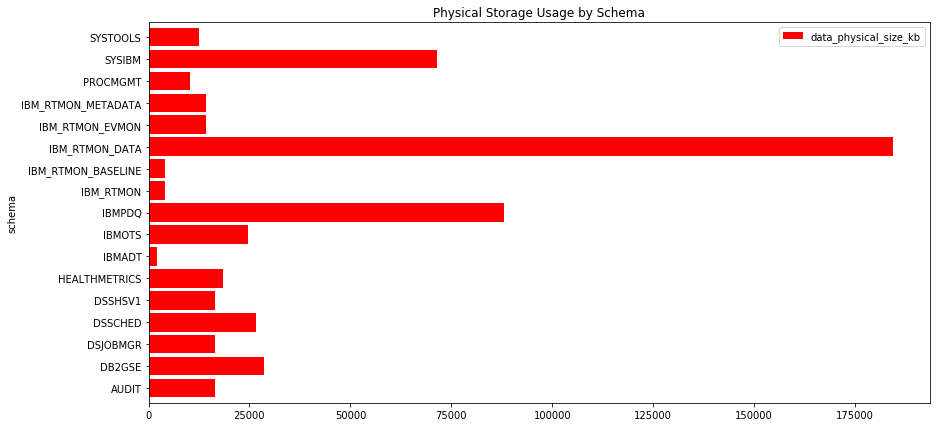

In [13]:
pd.DataFrame(data_dict['resources']).plot.barh( x="schema"
                                               ,y="data_physical_size_kb"
                                               ,title="Physical Storage Usage by Schema"
                                               ,figsize=(14, 7)
                                               ,zorder=2, width=0.85
                                               ,color="red")
plt.show()

#### Logical size in KB

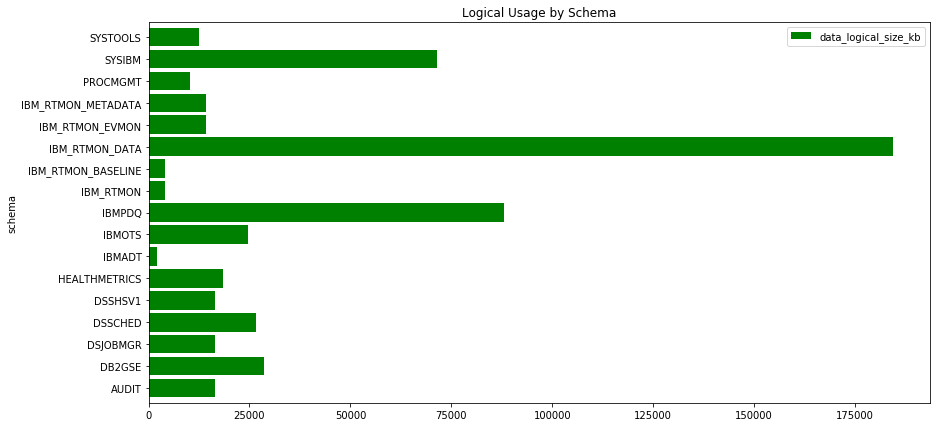

In [14]:
pd.DataFrame(data_dict['resources']).plot.barh( x="schema"
                                               ,y="data_logical_size_kb"
                                               ,title="Logical Usage by Schema"
                                               #,width="410"
                                               ,figsize=(14, 7)
                                               ,zorder=2, width=0.85
                                               ,color="green")
plt.show()

### Example: Get a list of backups for the particular DB2 deployment

In [15]:
conn.request("GET", "/dbapi/v4/backups", headers=headers)

res = conn.getresponse()
data = res.read()

In [16]:
data_dict = json.loads(data)
data_dict

{'trace': 'f1e1ddbf339d86c813b27dd5bcd2808e',
 'errors': [{'code': 'not_found',
   'message': 'HWCBAS0030E: The requested resource is not found in service dbapi.',
   'target': {'type': '', 'name': ''},
   'more_info': ''}]}

### Example: average number of rows read(rows/min) for a specified time frame

In [17]:
conn = http.client.HTTPSConnection(db2id['hostname'])
payload = "{\"userid\": " + db2id['username'] + ",\"password\": " + db2id['password'] + "}"
headers = { 'content-type': "application/json" }

In [18]:
date_time_format = "%m.%d.%Y %H:%M:%S"
start_TS = "01.01.2020 00:00:00" 
end_TS = "07.07.2020 00:00:00"

start_time_object = time.strptime(start_TS, date_time_format)
end_time_object = time.strptime(end_TS, date_time_format)

epoch_start_TS = time.mktime(start_time_object)
epoch_end_TS = time.mktime(end_time_object)

print(epoch_start_TS)
print(epoch_end_TS)

1577833200.0
1594072800.0


In [19]:
headers = {
    'content-type': "application/json",
    'authorization': "Bearer " + token ,
    'database_profile_name': "SOME_STRING_VALUE",
    # 'x-deployment-id': "{DEPLOYMENT_ID}"
    'x-deployment-id': ""
    }

rest_req = "/dbapi/v4/metrics/average_rows_read?start=" + str(epoch_start_TS) + "&end=" + str(epoch_end_TS)
rest_req

'/dbapi/v4/metrics/average_rows_read?start=1577833200.0&end=1594072800.0'

In [20]:

conn.request("GET", "/dbapi/v4/metrics/average_rows_read?start=1577833200&end=1594072800", headers=headers)
#conn.request("GET", rest_req, headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"rows_read_per_min":null}


### Example: Number of rows read over a period

In [21]:
# Retrieve the number of rows read over the last hour
endTime = int(time.time())*1000
startTime = endTime-(30*24*60*60*1000)

In [22]:
headers = {
    'content-type': "application/json",
    'authorization': "Bearer " + token ,
    'database_profile_name': "SAMPLE",
    'x-deployment-id': ""
    }

rest_req = "/dbapi/v4/metrics/rows_read?start=" + str(startTime) + "&end=" + str(endTime)
#rest_req

In [23]:
conn.request("GET", rest_req, headers=headers)

res = conn.getresponse()
data = res.read()
# print(data.decode("utf-8"))

In [24]:
jData = json.loads(data)

In [25]:
jData

{'timeseries': [{'rows_read_per_min': 5134,
   'interval': 304843,
   'timestamp': 1594359945265},
  {'rows_read_per_min': 903, 'interval': 297162, 'timestamp': 1594360242427},
  {'rows_read_per_min': 921, 'interval': 302516, 'timestamp': 1594360544943},
  {'rows_read_per_min': 5204, 'interval': 300811, 'timestamp': 1594360845754},
  {'rows_read_per_min': 898, 'interval': 298708, 'timestamp': 1594361144462},
  {'rows_read_per_min': 904, 'interval': 299097, 'timestamp': 1594361443559},
  {'rows_read_per_min': 5163, 'interval': 304112, 'timestamp': 1594361747671},
  {'rows_read_per_min': 1216, 'interval': 298479, 'timestamp': 1594362046150},
  {'rows_read_per_min': 901, 'interval': 297907, 'timestamp': 1594362344057},
  {'rows_read_per_min': 5204, 'interval': 301856, 'timestamp': 1594362645913},
  {'rows_read_per_min': 883, 'interval': 298343, 'timestamp': 1594362944256},
  {'rows_read_per_min': 893, 'interval': 300146, 'timestamp': 1594363244402},
  {'rows_read_per_min': 5197, 'interval

In [26]:
if jData['count'] > 0:
    df = pd.DataFrame(json_normalize(jData['timeseries'])) #extract just the timeseries data
    # print('Available Columns')
    # print(', '.join(list(df)))
else: 
    print('No data returned')
    
df

,rows_read_per_min,interval,timestamp
0,5134,304843,1594359945265
1,903,297162,1594360242427
2,921,302516,1594360544943
3,5204,300811,1594360845754
4,898,298708,1594361144462
5,904,299097,1594361443559
6,5163,304112,1594361747671
7,1216,298479,1594362046150
8,901,297907,1594362344057
9,5204,301856,1594362645913


## Summary
Using RESTful calls to Db2 removes much of the complexity of communicating with the database. There are no drivers required, no configuration file, nor any administration required on the client that is communicating with the database. All communication is done using RESTful API calls, which are available on all browsers and all operating systems. The calls to the database are replaced with standard POST and GET requests. Enabling RESTful support to Db2 opens up the type of applications that you can write and clients that you can connect to Db2 with.

#### Credits:  IBM 2020, Stefan Hummel [stefan.hummel@de.ibm.com]

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Apendix

### Example: Lists active database connections

In [ ]:
conn.request("GET", "/dbapi/v4/monitor/connections", headers=headers)

res = conn.getresponse()
data = res.read()

# print(data.decode("utf-8"))

In [ ]:
data_dict = json.loads(data)
df = data_dict['resources']
data_dict

In [ ]:
x = pd.DataFrame(data_dict['resources'])  
x

In [ ]:
pd.DataFrame(data_dict['resources']).plot.barh( x="schema"
                                               ,y="data_physical_size_kb"
                                               ,title="Physical Storage Usage by Schema"
                                               ,figsize=(14, 7)
                                               ,zorder=2, width=0.85
                                               ,color="red")
plt.show()